# PyCBC Inference code road map
### Collin Capano and Sebastian Khan

To illustrate how `pycbc_inference` works, we replicate the steps the program takes to setup and run the `emcee` sampler on the analytic 2D Normal distribution. We will use the same prior and setup as described in the Intro to PyCBC Inference tutorial. Instead of using a config file, we setup and the prior, sampler, and model directly.

### Prerequisites

In [1]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from __future__ import print_function

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
import numpy

import pycbc
from pycbc import distributions
from pycbc.waveform import generator
from pycbc import inference
from pycbc.inference import models

In [5]:
pycbc.init_logging(True)

## PyCBC Inference call graph

The following is a call graph showing the modules and classes `pycbc_inference` calls when it is running. Note:
 * A `sampler` class is used to interface with the sampling engines, like `emcee_pt`.
 * The sampler communicates with a `model` class. This calculates the `loglikelihood` and calls a `JointDistribution` to calculate the `logprior`.
 * When not using a test distribution, the `model` also calls the waveform generator to generate a waveform. However, since we will be using a test distribution, this step is not taken in this notebook.

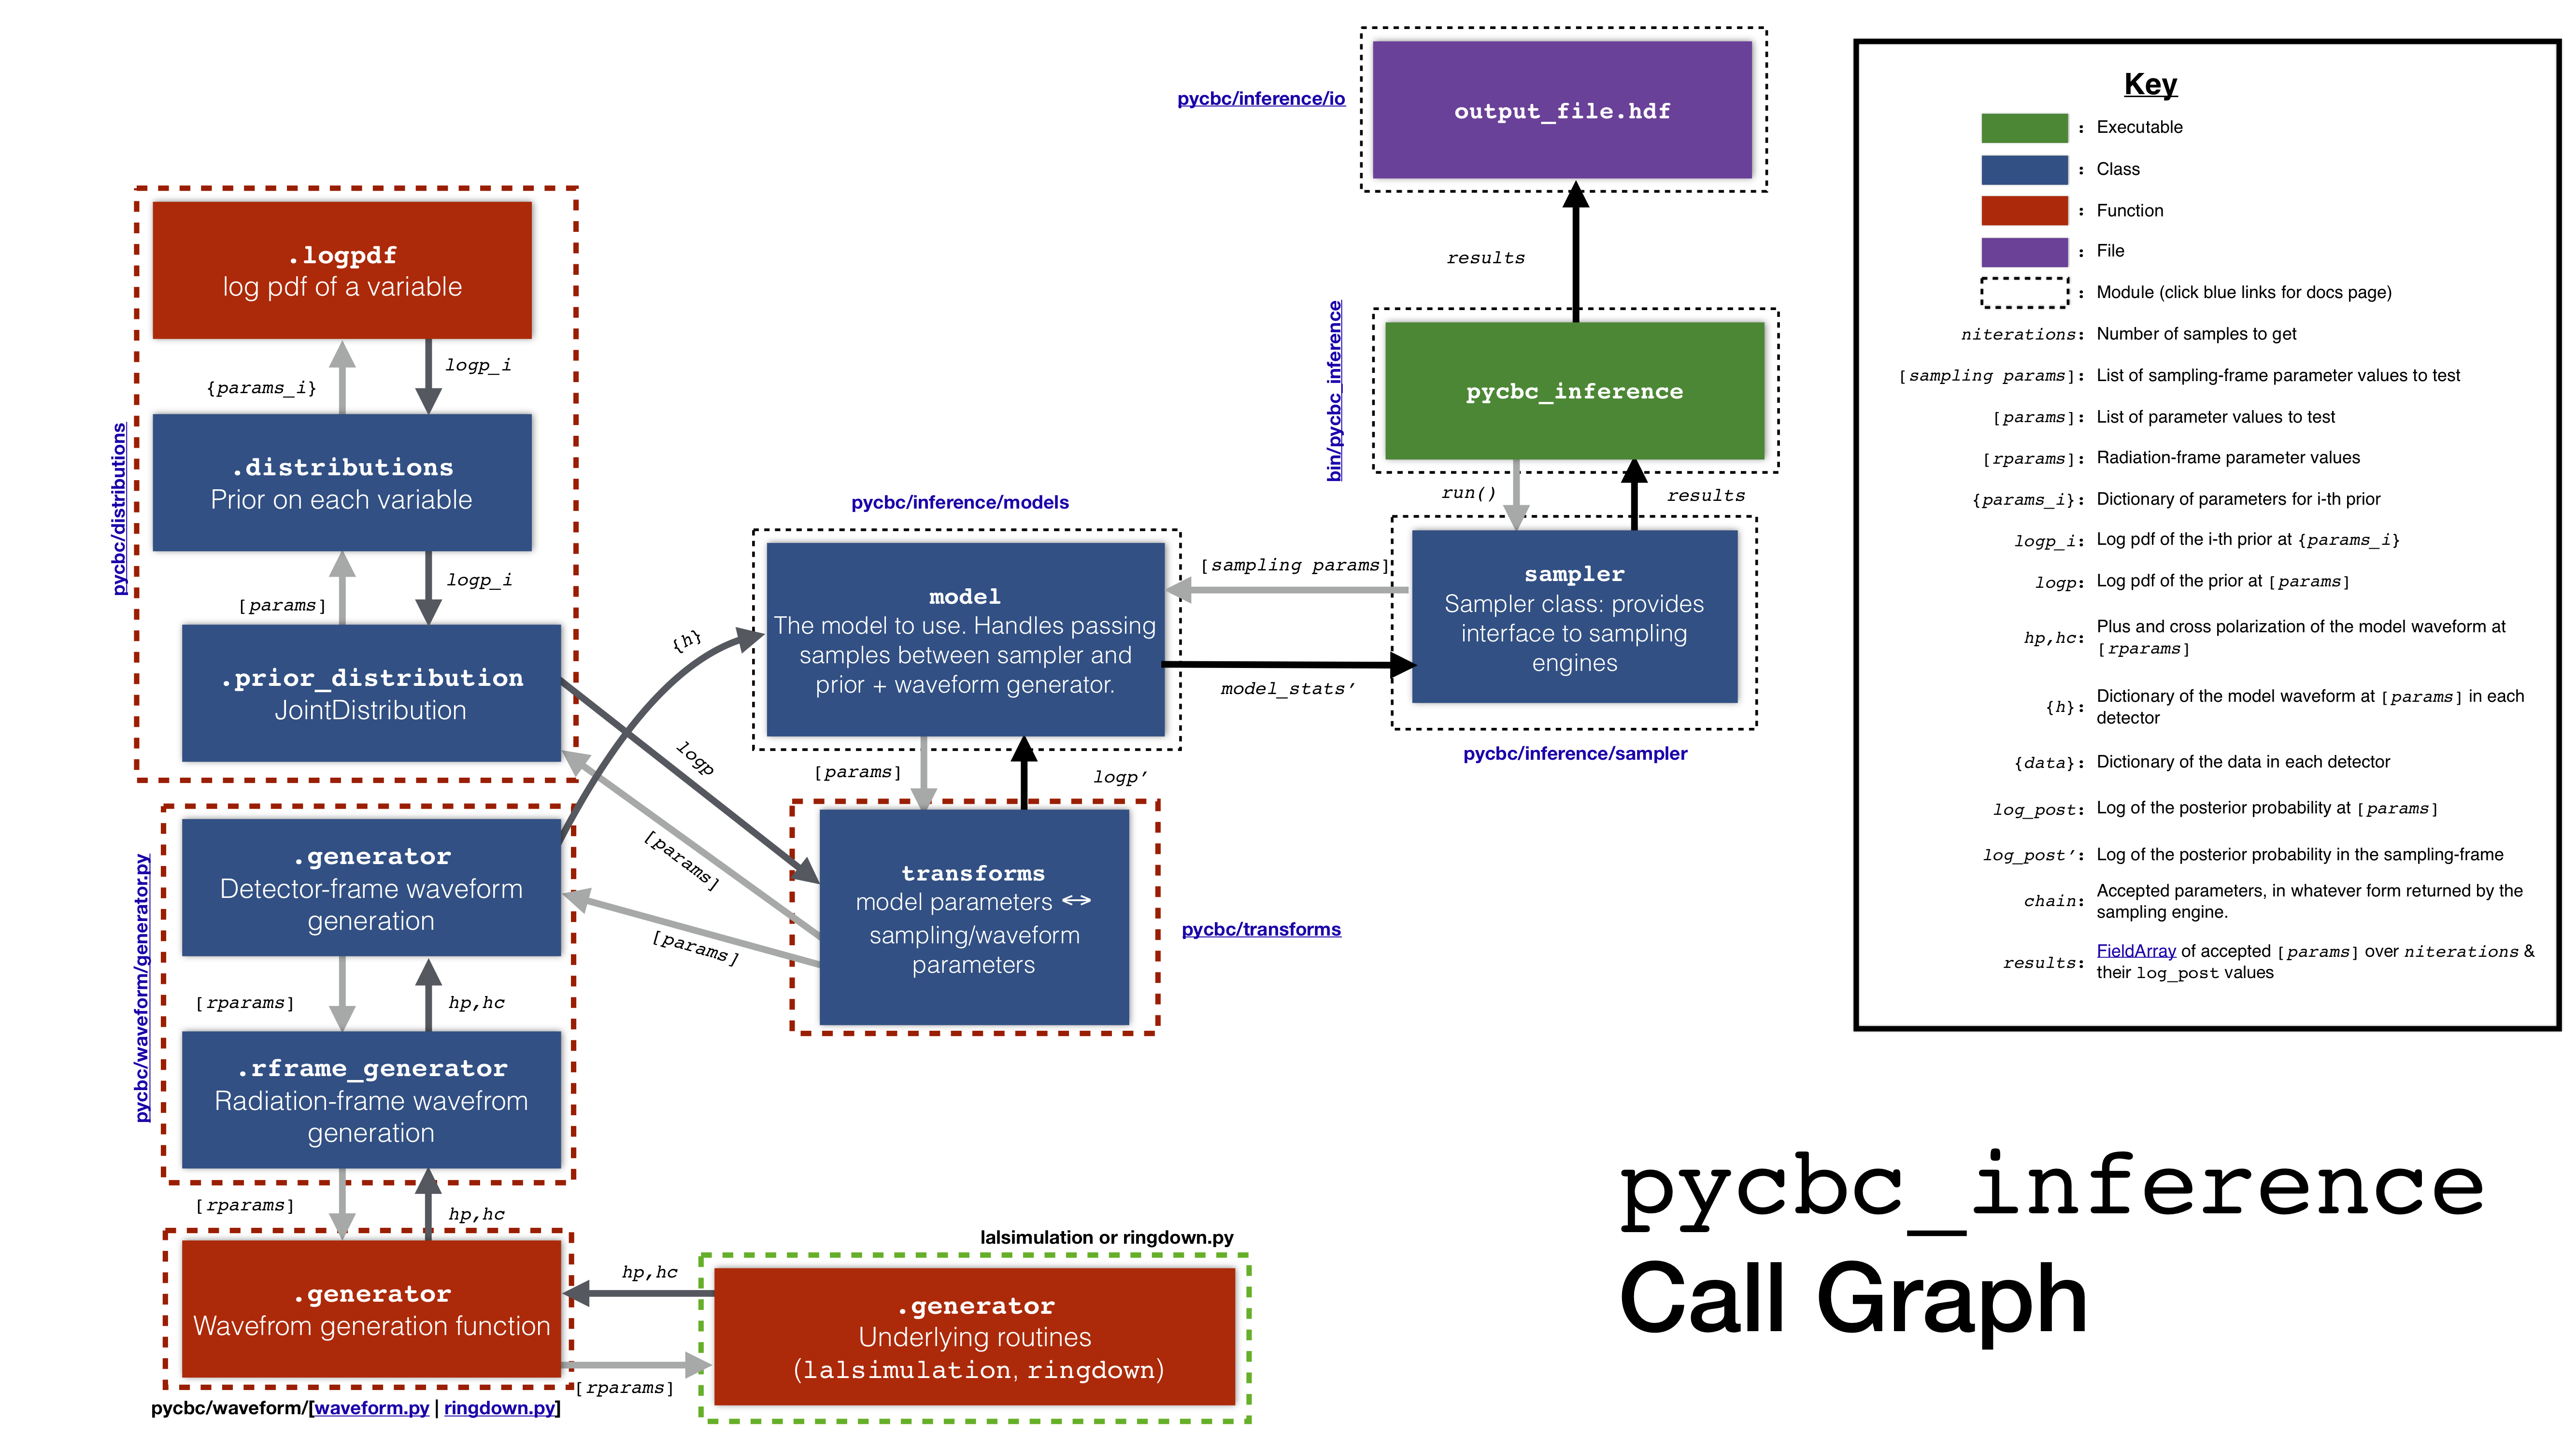

In [6]:
from IPython.display import Image
Image("pycbc_inference_callgraph.png")

## 1. Set up the prior

We first need to create an instance of the `Uniform` distribution.

In [7]:
xdist = distributions.Uniform(x=(-10, 10))
ydist = distributions.Uniform(y=(-10, 10))

Now we need to create a `JointDistribution` to handle the two distributions:

In [8]:
jointdist = distributions.JointDistribution(["x","y"], xdist, ydist)

## 2. Set up the model

We now create a `model` instance. We will tell it that it has two parameters, called `x` and `y`, and we provide the `jointdist` as the prior.

In [9]:
model = models.models["test_normal"](["x","y"], prior=jointdist)

The model can produce random draws from the prior:

In [10]:
random_draws = model.prior_rvs(size=3)
print('x:', random_draws['x'])
print('y:', random_draws['y'])

x: [-7.85810837  4.67915481  6.55477767]
y: [ 7.89252773 -0.59634212  1.20855589]


The model is what evaluates the `logprior` and `loglikelihood` values. We do that by first providing it a point to evaluate; we will use the first point from our random draw:

In [11]:
test_point_x = random_draws['x'][0]
test_point_y = random_draws['y'][0]
print(test_point_x, test_point_y)

-7.8581083745176965 7.892527728701481


In [12]:
model.update(x=test_point_x, y=test_point_y)

We can now get the `logprior` and `loglikelihood` values by calling the appropriate attributes:

In [13]:
print("logprior at point:", model.logprior)
print("loglikelihood at point:", model.loglikelihood)

logprior at point: -5.991464547107982
loglikelihood at point: -63.858807653402806


Or, we can call `logposterior` which is the sum of the `logprior` and `loglikelihood` values:

In [14]:
model.logposterior

-69.85027220051079

When the sampler runs, it calls `model.update` for each new point it wants to test, then gets the statistics it needs.

## 3. Set up the sampler

With the model initialized, we can now set up the sampler:

### a. Initialize

In [15]:
sampler = inference.sampler.emcee.EmceeEnsembleSampler(model, nwalkers=1000, checkpoint_interval=100, nprocesses=4)

### b. Set the output file

In [16]:
sampler.setup_output(output_file="normal2d.hdf", force=True)

2019-05-13 15:46:59,243 Looking for checkpoint file


### c. Set the termination condition

In this case, we will run for 200 iterations.

In [17]:
sampler.set_target(niterations=200)

### d. Set the starting point

The `set_initial_conditions` method sets the starting positions for the walkers. It does this by calling the model's `prior_rvs` function.

In [18]:
sampler.set_initial_conditions()

## 3. Run the sampler

In [19]:
sampler.run()

The run command runs the sampler until the termination condition set by `set_target` is met (in this case, when it reaches 200 iterations), checkpointing along the way. The results were dumped to the checkpoint file.

## Plot the results

We can load the samples from the checkpoint file and plot them.

In [20]:
fp = inference.io.loadfile("normal2d.hdf.checkpoint", "r")

In [21]:
samples = fp.read_samples(['x', 'y', 'loglikelihood'])

2019-05-13 15:47:00,286 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/Users/cdcapano/.virtualenvs/hm_chisq/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


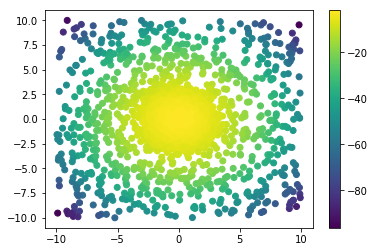

In [22]:
plt.figure()
plt.scatter(samples['x'], samples['y'], c=samples['loglikelihood'])
plt.colorbar()
plt.show()

In [23]:
fp.close()